# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
print(os.getcwd())
# os.chdir("../../")
# print(os.getcwd())

/work/nightcrawler-ds-pipeline


In [3]:
import sys
# sys.path.pop()
# sys.path.append('/work/nightcrawler-ds-pipeline')
print(sys.path)

['/root/.pyenv/versions/3.10.14/lib/python310.zip', '/root/.pyenv/versions/3.10.14/lib/python3.10', '/root/.pyenv/versions/3.10.14/lib/python3.10/lib-dynload', '', '/root/.pyenv/versions/env_nw_country_filtering_pipeline/lib/python3.10/site-packages', '/work/nightcrawler-ds-helpers', '/work/nightcrawler-ds-pipeline']


# Main

## Country filterer

### Settings

In [4]:
import time

from nightcrawler.process.s05_country_filterer import MasterCountryFilterer
from helpers.settings import Settings

SETTINGS = Settings().country_filtering
DEFAULT_CONFIG = SETTINGS.config
DEFAULT_CONFIG_URL_FILTERER = SETTINGS.config_url_filterer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Dataset

In [5]:
from helpers import utils_io

blob_2024_top_domain_raw = utils_io.load_dataset(path_data="/work/medicrawl-data-science/datasets/004_country_filtering/data", 
                                                 country="ch/blob_2024_dataset", 
                                                 file_name="blob_2024_top_domain_raw")
# blob_2024_top_domain_raw = pd.read_csv("/work/medicrawl-data-science/datasets/004_country_filtering/data/ch/blob_2024_dataset/blob_2024_top_domain_raw.csv")
blob_2024_top_domain_raw.rename(columns={"pageUrl": "page_url"}, inplace=True)
display(blob_2024_top_domain_raw.head(1))

,idx,keywordQuery,platform,offerRoot,page_url,source,source_nb_rows,page_status,page_type,product_domain,...,offerPrice,title,specs,humanLanguage,crawledAt,productOrigin,keywordType,offerUid,matchImageUrl,domain
0,70.0,"""Masushita Bang Bang Strongman""",google.ch,GOOGLE_SHOPPING,https://www.ebay.co.uk/itm/175973641605?chn=ps...,ebay.co.uk,2440,found,ecommerce_product,other,...,£25.00,One Punch Man Tatsumaki Figure Relax Time Banp...,"{'condition': ""New: A brand-new, unused, unope...",en,2024-03-03T02:28:47+00:00,NaN,text,22bf808f69c6ed5f119501dadf42f190,NaN,www.ebay.co.uk


### Perform filtering

In [6]:
# Instantiate filterer
filterer = MasterCountryFilterer(
    filterer_name=DEFAULT_CONFIG["FILTERER_NAME"],
    country=DEFAULT_CONFIG["COUNTRY"],
    config=DEFAULT_CONFIG,
    config_filterer=DEFAULT_CONFIG_URL_FILTERER
)

# Perform filtering
time_start = time.time()
blob_2024_top_domain_raw_cf = filterer.perform_filtering(blob_2024_top_domain_raw)
time_end = time.time()

# Compute time elapsed
blob_2024_top_domain_raw_cf["time_elapsed"] = time_end - time_start
display(blob_2024_top_domain_raw_cf.head(1))
print(blob_2024_top_domain_raw_cf.filterer_name.value_counts())

100%|██████████| 73/73 [00:00<00:00, 2931.62it/s]


,idx,keywordQuery,platform,offerRoot,page_url,source,source_nb_rows,page_status,page_type,product_domain,...,filterer_name,index,url_shipping_policy_page,button_words_shipping_policy_page,keywords_in_shipping_policy_page,shipping_policy_page_information_detail,shipping_policy_page_comment,productOrigin,2_keywords_in_shipping_policy_page,time_elapsed
0,70.0,"""Masushita Bang Bang Strongman""",google.ch,GOOGLE_SHOPPING,https://www.ebay.co.uk/itm/175973641605?chn=ps...,ebay.co.uk,2440,found,ecommerce_product,other,...,unknown,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.039088


filterer_name
unknown    60
url        13
Name: count, dtype: int64


## DeliveryPolicyExtractor

### Settings

In [7]:
from nightcrawler.process.s06_delivery_page_detection import ShippingPolicyFilterer
from helpers.settings import Settings
from helpers.api.llm_apis import MistralAPI
from helpers.api.zyte_api import ZyteAPI

SETTINGS = Settings().delivery_policy
DEFAULT_CONFIG = SETTINGS.config
DEFAULT_CONFIG_FILTERER = SETTINGS.config_filterer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Dataset

In [8]:
# print(blob_2024_top_domain_raw_cf.columns)

In [9]:
blob_2024_top_domain_raw_cf = blob_2024_top_domain_raw_cf[
    ["page_url", "domain", "filterer_name", "RESULT", "shipping_in_swiss"]]

### Perform filtering

In [10]:
# Instantiate filterer
filterer = ShippingPolicyFilterer(
    country=DEFAULT_CONFIG["COUNTRY"],
    config=DEFAULT_CONFIG,
    config_filterer=DEFAULT_CONFIG_FILTERER,
    zyte_api_product_page=ZyteAPI(),
    zyte_api_policy_page=ZyteAPI(),
    mistral_api=MistralAPI(),
)

# Perform filtering
time_start = time.time()
blob_2024_top_domain_raw_spf = filterer.perform_filtering(blob_2024_top_domain_raw_cf)
time_end = time.time()

# Compute time elapsed
blob_2024_top_domain_raw_spf["time_elapsed"] = time_end - time_start
# 3min

2024-10-18T10:30:08.029 | nightcrawler_logger | INFO | Domain www.ebay.co.uk labeled by hand as positive


2024-10-18T10:30:08.030 | nightcrawler_logger | INFO | Domain www.ebay.de labeled by hand as positive
2024-10-18T10:30:08.031 | nightcrawler_logger | INFO | Domain www.herbkart.com labeled by hand as positive
2024-10-18T10:30:08.033 | nightcrawler_logger | INFO | Extracting html content of 
the page https://www.gosupps.com/everlong-detox-tea-v2-0-enhanced-28-day-ultimate-teatox-morning-boost-night-cleanse-burn-fat-reduce-bloating-accelerate-weight-loss-comprehensive-solution-to-regenerate-your-body-in-natural-way.html?srsltid=AfmBOorrXfXboevSiZ7aV-p5CtpaIEBxBy-MrHPxW1VGc8Z4Aw_9L4X0RxQ 
with domain www.gosupps.com
2024-10-18T10:30:08.034 | nightcrawler_logger | INFO | Domain www.hood.de labeled by hand as positive
2024-10-18T10:30:08.034 | nightcrawler_logger | INFO | Domain www.ebay.com labeled by hand as positive
2024-10-18T10:30:08.035 | nightcrawler_logger | INFO | Extracting html content of 
the page https://www.farmae.de/kaffee-reishi-bio-250g-924824992.html?srsltid=AfmBOoo7A-E_tq

In [11]:
print(blob_2024_top_domain_raw_spf.columns)

Index(['page_url', 'domain', 'filterer_name', 'RESULT', 'shipping_in_swiss',
       'label_justif', 'index', 'urls_shipping_policy_page_found_analysis',
       'url_shipping_policy_page_kept', 'time_elapsed'],
      dtype='object')


## Evaluate

In [ ]:
# sys.path.append('/work/medicrawl-data-science/projects/004_country_filtering')
# from src.evaluating import evaluate_filterers_dataset_labeled

In [12]:
import sklearn
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def get_confusion_matrix(y_true, y_pred_label, kwargs):
    fig = plt.figure()

    conf_matrix = pd.crosstab(
        index=y_true,
        columns=y_pred_label,
        rownames=["True"],
        colnames=["Predicted"],
    )

    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")

    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
    plt.title("Confusion Matrix")
    plt.show()

    return conf_matrix

def evaluate_filterers_dataset_labeled(dataset_labeled, **kwargs):
    # Assess filtering
    ## initialize metrics
    metrics = {}
    ## compute duration metric
    metrics = {
        **metrics,
        # "duration": time_end - time_start,
    }
    ## compute distribution metrics
    metrics = {
        **metrics,
        "positives": dataset_labeled["RESULT"].eq(+1).sum(),
        "unknowns": dataset_labeled["RESULT"].eq(0).sum(),
        "negatives": dataset_labeled["RESULT"].eq(-1).sum(),
    }
    ## compute classification metrics
    if "LABEL" in dataset_labeled.columns:
        # ATTENTION: in "RESULT" column there will be no NaN whatever happens because of the astype(bool)
        dataset_labeled["RESULT"] = (
            dataset_labeled["RESULT"].map({+1: True, 0: False, -1: False}).astype(bool)
        )
        assert (
            dataset_labeled["RESULT"].isna().sum() == 0
        ), "There are NaN values in the RESULT column"

        metrics = {
            **metrics,
            "accuracy": accuracy_score( # sklearn.metrics.
                dataset_labeled["LABEL"], dataset_labeled["RESULT"]
            ),
            "precision": precision_score( # sklearn.metrics.
                dataset_labeled["LABEL"],
                dataset_labeled["RESULT"],
                zero_division=np.nan,
            ),
            "recall": recall_score( # sklearn.metrics.
                dataset_labeled["LABEL"], dataset_labeled["RESULT"]
            ),
            "f1": f1_score( # sklearn.metrics.
                dataset_labeled["LABEL"], dataset_labeled["RESULT"]
            ),
        }

        # Display and save confusion matrix
        _ = get_confusion_matrix(
            y_true=dataset_labeled["LABEL"],
            y_pred_label=dataset_labeled["RESULT"],
            kwargs=kwargs,
        )

    return metrics

In [13]:
# blob_2024_top_domain_raw_spf["shipping_in_swiss"].value_counts()
# blob_2024_top_domain_raw_spf["LABEL"].value_counts()
blob_2024_top_domain_raw_spf["RESULT"].value_counts()

RESULT
 1    55
 0    15
-1     3
Name: count, dtype: int64

In [14]:
blob_2024_top_domain_raw_spf["LABEL"] = (
    blob_2024_top_domain_raw_spf["shipping_in_swiss"]
    .map({"yes": True, "no_info": False, "unknown": False, "no": False})
    .astype(bool)
)

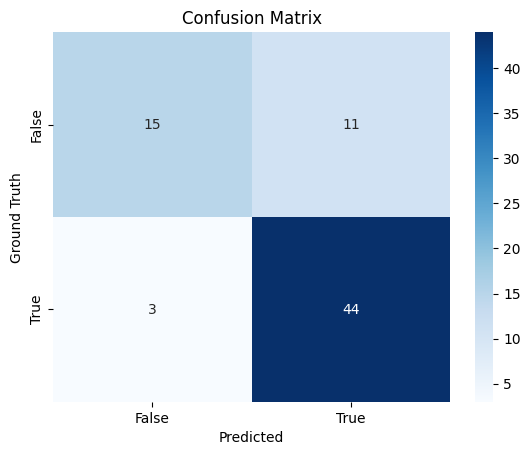

{'positives': 55,
 'unknowns': 15,
 'negatives': 3,
 'accuracy': 0.8082191780821918,
 'precision': 0.8,
 'recall': 0.9361702127659575,
 'f1': 0.8627450980392157}

In [15]:
evaluate_filterers_dataset_labeled(blob_2024_top_domain_raw_spf)

# Main old

In [ ]:
from helpers.context import Context
from helpers import utils

## Zyte results

In [ ]:
zyte_results = utils.read_json(target_path="./data/output/2024-10-17_14-42-34_aspirin_defaultuser",
                               target_file="3_extract_zyte.json")
# print(type(zyte_results), zyte_results.keys(), "\n", zyte_results)

In [ ]:
from nightcrawler.base import MetaData, CrawlResultData, PipelineResult
zyte_results = PipelineResult(meta=MetaData(zyte_results["meta"]), 
                              results=[CrawlResultData(offerRoot=dict_results.get("OfferRoot"),
                                                       url=dict_results.get("url")) for dict_results in zyte_results["results"]]) # CrawlResultData(zyte_results["results"])

In [ ]:
# Check
# print(zyte_results.meta)
# print(zyte_results.results)
# print(zyte_results.results.url)
# print(result.url for result in zyte_results.results)

## CountryFilterer

In [ ]:
from nightcrawler.process.s05_country_filterer import CountryFilterer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
from nightcrawler.cli.full_pipeline import apply
import argparse
# Create the namespace object manually
args = argparse.Namespace(reverse_image_search=True, searchitem="wasser", number_of_results=1)
apply(args)
# python -m nightcrawler fullrun -n=1 wasser

In [ ]:
country_filtering_results = CountryFilterer(context=Context).apply(
    previous_step_results=zyte_results # zyte_results_dot_dict # zyte_results
)

## DeliveryPolicyExtractor

In [ ]:
from nightcrawler.process.s06_delivery_page_detection import DeliveryPolicyExtractor

# Old

In [ ]:
# zyte_results_meta = zyte_results["meta"]
# print(type(zyte_results_meta), zyte_results_meta.keys(), "\n", zyte_results_meta)

# zyte_results_results = zyte_results["results"]
# print(type(zyte_results_results), zyte_results_results.keys(), "\n", zyte_results_results)

In [ ]:
# class DotDict(dict):
#     def __init__(self, *args, **kwargs):
#         super(DotDict, self).__init__(*args, **kwargs)
#         for key, value in self.items():
#             # Convert sub-dictionaries to DotDict recursively
#             if isinstance(value, dict):
#                 self[key] = DotDict(value)
#             # If value is a list, check for dictionaries and convert them
#             elif isinstance(value, list):
#                 self[key] = [DotDict(item) if isinstance(item, dict) else item for item in value]

#     def __getattr__(self, key):
#         try:
#             return self[key]
#         except KeyError:
#             raise AttributeError(f"Attribute {key} not found")
    
#     def __setattr__(self, key, value):
#         self[key] = value

#     def __delattr__(self, key):
#         try:
#             del self[key]
#         except KeyError:
#             raise AttributeError(f"Attribute {key} not found")


In [ ]:
# zyte_results_doc_dict = DotDict(zyte_results)

In [6]:
# delivery_policy_detector = DeliveryPolicyDetector(context=Context)
# print(delivery_policy_detector.config)

In [ ]:
# delivery_policy_filtering_results = DeliveryPolicyDetector(context=Context).apply(
#     previous_step_results=processor_results
# )

In [ ]:
# processor_results = utils.read_json(target_path="./data/output/2024-10-11_09-01-35_wasser_defaultuser", # "./data/output"
#                                        target_file="4_process_raw.json") # "04_process_filtered_country.json"
# print(processor_results)

In [ ]:
# delivery_policy_detector = DeliveryPolicyDetector(context=Context)
# print(delivery_policy_detector.config)

In [8]:
# delivery_policy_filtering_results = DeliveryPolicyDetector(context=Context).apply(
#     previous_step_results=processor_results
# )

# Tests

In [41]:
# import abc

# class Test(abc.ABC):
#     def __init__(self):
#         self.text = "Hello World"
    
#     @staticmethod
#     def print_message(message):
#         print(message)

#     def do_smt(self):
#         self.print_message(message="Test" + " " + self.text)

# test = Test()
# test.do_smt()

# Draft

In [5]:
string_test = "known_domains" # "url"
if string_test not in ["known_domains", "unknown"]:
    print("Enter condition")

In [2]:
a, b = 1, None # 2
if a and b:
    print("Both are True")

In [1]:
if True and not False:
    print("test")

test


In [1]:
import pandas as pd
dict_1 = {"name": "Alice", "age": 25}
dict_2 = {"name": "Bob", "sex": "M"}

df = pd.DataFrame([dict_1, dict_2])
display(df)

,name,age,sex
0,Alice,25.0,NaN
1,Bob,NaN,M


In [1]:
a = 3 or 4
print(a)

3


In [3]:
for _, row in df.iterrows():
    if row["name"] == "Alice":
        row["person_type"] = "human"
    print(row)

name           Alice
age             25.0
sex              NaN
person_type    human
Name: 0, dtype: object
name    Bob
age     NaN
sex       M
Name: 1, dtype: object


In [ ]:
# # Example usage
# nested_dict = {
#     'k1': {'sk1': 1, 'sk2': 2},
#     'k2': [{'sk1': 3, 'sk2': 4}, {'sk1': 5, 'sk2': 6}]
# }

# dot_dict = DotDict(nested_dict)

# # Accessing keys and subkeys with dot notation
# print(dot_dict.k1.sk1)           # Output: 1
# print(dot_dict.k2[0].sk1)        # Output: 3
# print(dot_dict.k2[1].sk2)        # Output: 6

# # Setting new values
# dot_dict.k2[0].sk3 = 7
# print(dot_dict.k2[0].sk3)        # Output: 7

In [38]:
# class DotDict(dict):
#     def __init__(self, *args, **kwargs):
#         super(DotDict, self).__init__(*args, **kwargs)
#         for key, value in self.items():
#             # Convert sub-dictionaries to DotDict recursively
#             if isinstance(value, dict):
#                 self[key] = DotDict(value)

#             # If value is a list, check for dictionaries and convert them
#             elif isinstance(value, list):
#                 self[key] = [DotDict(item) if isinstance(item, dict) else item for item in value]

#     def __getattr__(self, key):
#         try:
#             return self[key]
#         except KeyError:
#             raise AttributeError(f"Attribute {key} not found")
    
#     def __setattr__(self, key, value):
#         self[key] = value

#     def __delattr__(self, key):
#         try:
#             del self[key]
#         except KeyError:
#             raise AttributeError(f"Attribute {key} not found")
        
# zyte_results_dot_dict = DotDict(nested_dict=zyte_results)
# print(zyte_results_dot_dict.meta)


In [39]:
# class DotDict(dict):
#     def __init__(self, *args, **kwargs):
#         super(DotDict, self).__init__(*args, **kwargs)
#         for key, value in self.items():
#             # Convert sub-dictionaries to DotDict recursively
#             if isinstance(value, dict):
#                 self[key] = DotDict(value)

#             # If value is a list, check for dictionaries and convert them
#             elif isinstance(value, list):
#                 self[key] = [DotDict(item) if isinstance(item, dict) else item for item in value]

#     def __getattr__(self, key):
#         try:
#             return self[key]
#         except KeyError:
#             raise AttributeError(f"Attribute {key} not found")
    
#     def __setattr__(self, key, value):
#         self[key] = value

#     def __delattr__(self, key):
#         try:
#             del self[key]
#         except KeyError:
#             raise AttributeError(f"Attribute {key} not found")
        
# zyte_results_dot_dict = DotDict(nested_dict=zyte_results)
# print(zyte_results_dot_dict.meta)


In [40]:
# class DictToObject:
#     def __init__(self, dictionary):
#         for key, value in dictionary.items():
#             if isinstance(value, dict):
#                 self.__dict__[key] = DictToObject(value)
#             else:
#                 self.__dict__[key] = value

#     def __repr__(self):
#         return f"{self.__class__.__name__}({self.__dict__})"

# # Example usage
# data = {
#     'k1': {
#         'sk1': 'value1',
#         'sk2': 'value2'
#     },
#     'k2': {
#         'sk1': 'value3',
#         'sk2': 'value4'
#     }
# }

# obj = DictToObject(data)

# # Accessing the values using dot notation
# print(obj.k1)  # Output: value1